In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
from collections import Counter

For our Animal Care Exploratory Data Analysis, we have two datasets pertaining to details about animals when they were taken in for care and when they were left out after care. 

1. Intake.csv -> Contains the details when taken in
2. Outcomes.csv -> Contains the details when animals were released

The very first key step in analyzing the data is to combine both the datasets into a single common data to ease analysis. When combining, the key factor that needs to be kept under consideration is that all details are mapped correctly for a single entity. I did this keeping the title "Animal Id" as the sole factor in mapping correct data from 2 datasets.

The next important thing while merging the datasets is to drop duplicate columns to reduce data size and keep only those titles not common in either of the data. This way all titles from both the datasets are used and mapped

# MERGING DATASETS

In [96]:
df1 = pd.read_csv("../Datasets/Intake.csv")
df2 = pd.read_csv("../Datasets/Outcome.csv")

In [97]:
# merged = pd.merge(df1, df2, on="Animal ID", how="outer", suffixes=('_df1', '_df2'))

# Remove columns that are duplicates after merge
#for col in merged.columns:
#    if col.endswith("_df2") and col.replace("_df2", "_df1") in merged.columns:
#        merged[col] = merged[col.replace("_df2", "_df1")].combine_first(merged[col])
#        merged = merged.drop(columns=[col])


#merged.to_csv("output1.csv", index=False)

# NEW DATASET

In [98]:
df = pd.read_csv("../Datasets/Animal.csv")

In [99]:
print(f"No of rows: {df.shape[0]}")
print(f"No of columns: {df.shape[1]}")

No of rows: 161674
No of columns: 17


In [100]:
df.columns.to_list()

['Animal ID',
 'Name_df1',
 'DateTime_df1',
 'MonthYear_df1',
 'Found Location',
 'Intake Type',
 'Intake Condition',
 'Animal Type_df1',
 'Sex upon Intake',
 'Age upon Intake',
 'Breed_df1',
 'Color_df1',
 'Date of Birth',
 'Outcome Type',
 'Outcome Subtype',
 'Sex upon Outcome',
 'Age upon Outcome']

In [101]:
df.isnull().sum()

Animal ID               0
Name_df1            40699
DateTime_df1          815
MonthYear_df1         815
Found Location        815
Intake Type           815
Intake Condition      815
Animal Type_df1       815
Sex upon Intake       816
Age upon Intake       815
Breed_df1             815
Color_df1             815
Date of Birth         431
Outcome Type          460
Outcome Subtype     98415
Sex upon Outcome      432
Age upon Outcome      436
dtype: int64

As we can clearly see, there are a lot of missing values which might seem irrelevant but thats not the case
1. Since we are dealing with animals, its obvious that animals don't have names unless they are owned ones
2. Missing found location might pe possible that the place from where the animal was taken was not known to the personel
3. Outcome type can be differed as the fate of animals were not known owing to the fact that most of these animals were returned to owner
4. Intake Type missing might indicate that medical team forgot to put entry about how did they come across the animal

Like this, all the other columns hav their own missing significane or faults. We need to analyze manually which columns to be treated in what manner

# DATA CLEANING

In [102]:
df['Name_df1'] = df['Name_df1'].fillna('Unknown')
df['Name_df1'].isnull().sum()

np.int64(0)

After merging the two datasets we get out new dataset `Animal.csv` and the different columns available are listed above.

Upon thorough analysis, we can still see there are still duplicates available and that was not handled properly during merging.
The reason behind this is the fact that the column names are different. So even though some columns contains the exact same data they were not identified and while merging, `Pandas` too it to be different columns.

I will do the following steps now to make our dataset more accurate and reduce its dimensions

1. List out the columns having the exact same data and group them
2. Keep a common column name which represents that particular data to remove biasness

In [103]:
col1 = 'Sex upon Intake'
col2 = 'Sex upon Outcome'

df[col2] = df[col1]

In [104]:
df['Age upon Intake'] = df['Age upon Intake'].astype(str).str.extract(r'(\d+)').astype(float)
df['Age upon Outcome'] = df['Age upon Outcome'].astype(str).str.extract(r'(\d+)').astype(float)

# Step 3: Ensure Outcome >= Intake
df['Age upon Outcome'] = df[['Age upon Intake', 'Age upon Outcome']].max(axis=1)

# Step 4: Group and aggregate
df_cleaned = df.groupby(['Animal ID', 'Intake Condition', 'DateTime_df1']).agg({
    'Name_df1': 'first',
    'Found Location': 'first',
    'Intake Type': 'first',
    'Animal Type_df1': 'first',
    'Sex upon Intake': 'first',
    'Age upon Intake': 'max',
    'Breed_df1': 'first',
    'Color_df1': 'first',
    'Date of Birth': 'first',
    'Outcome Type': 'first',
    'Outcome Subtype': 'first',
    'Sex upon Outcome': 'first',
    'Age upon Outcome': 'max',
    'MonthYear_df1': 'first'
}).reset_index()

In [105]:
merged_cols = set()

for i, col1 in enumerate(df.columns):
    if col1 in merged_cols:
        continue
    for col2 in df.columns[i+1:]:
        if col2 in merged_cols:
            continue
        # Check if columns are exactly equal
        if df[col1].equals(df[col2]):
            # Merge into a single column (keep col1 name)
            print(f"Merging '{col2}' into '{col1}'")
            df = df.drop(columns=[col2])
            merged_cols.add(col2)

print("Cleaned DataFrame with identical columns merged:")
print(df.columns.to_list)

Merging 'MonthYear_df1' into 'DateTime_df1'
Merging 'Sex upon Outcome' into 'Sex upon Intake'
Cleaned DataFrame with identical columns merged:
<bound method IndexOpsMixin.tolist of Index(['Animal ID', 'Name_df1', 'DateTime_df1', 'Found Location',
       'Intake Type', 'Intake Condition', 'Animal Type_df1', 'Sex upon Intake',
       'Age upon Intake', 'Breed_df1', 'Color_df1', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Age upon Outcome'],
      dtype='object')>


Some columns which have missing values, using some other column we can predict it or if certain columns represent the same data, its better to drop them and keep just a single column to remove duplicate entries under different column names

In [106]:
df.isnull().sum()

Animal ID               0
Name_df1                0
DateTime_df1          815
Found Location        815
Intake Type           815
Intake Condition      815
Animal Type_df1       815
Sex upon Intake       816
Age upon Intake       815
Breed_df1             815
Color_df1             815
Date of Birth         431
Outcome Type          460
Outcome Subtype     98415
Age upon Outcome        0
dtype: int64

In [107]:
df['Found Location'] = df['Found Location'].fillna('Unknown')
df['Intake Type'] = df['Intake Type'].fillna('Unknown')
df['Animal Type_df1'] = df['Animal Type_df1'].fillna('Unknown')
df['Breed_df1'] = df['Breed_df1'].fillna('Unknown')
df['Color_df1'] = df['Color_df1'].fillna('Unknown')
df['Outcome Type'] = df['Outcome Type'].fillna("Unknown")
df['Outcome Subtype'] = df['Outcome Subtype'].fillna("Unknown")


df['Intake Condition'] = df['Intake Condition'].fillna('Not Recorded')
df['DateTime_df1'] = df['DateTime_df1'].fillna('Not Recorded')
df['Date of Birth'] = df['Date of Birth'].fillna('Not Recorded')


df['Sex upon Intake'] = df['Sex upon Intake'].fillna('Undetermined')


In [108]:
df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
df['DateTime_df1'] = pd.to_datetime(df['DateTime_df1'], errors='coerce')

# Function to calculate age or set 'Undetermined'
def calculate_age(row):
    if pd.notnull(row['Age upon Intake']):
        return row['Age upon Intake']
    elif pd.notnull(row['DateTime_df1']) and pd.notnull(row['Date of Birth']):
        return round((row['DateTime_df1'] - row['Date of Birth']).days / 365, 1)
    else:
        return 'Undetermined'

# Apply function
df['Age upon Intake'] = df.apply(calculate_age, axis=1)
df['Date of Birth'] = df['Date of Birth'].fillna("Unknown")
df['DateTime_df1'] = df['DateTime_df1'].fillna("Unknown")

We used the concept where to determine the Age of the animal, we used Date of birth and the time when the animal was taken into care to find the age. If the entries were missing we simply filled it with Undetermined

In [109]:
df.isnull().sum()

Animal ID           0
Name_df1            0
DateTime_df1        0
Found Location      0
Intake Type         0
Intake Condition    0
Animal Type_df1     0
Sex upon Intake     0
Age upon Intake     0
Breed_df1           0
Color_df1           0
Date of Birth       0
Outcome Type        0
Outcome Subtype     0
Age upon Outcome    0
dtype: int64

As we can finally see, our entire dataset is now cleaned with no missing values. All the missing entries have been handled as per the data available to else used some terminology to identify the missing data.

Let us now import this cleaned dataset into a fresh csv file and work with that

In [110]:
df.to_csv("Final_AnimalCare.csv",index=False)

In [2]:
df = pd.read_csv('Final_AnimalCare.csv',low_memory=False)

# DATA EXPLORATION and VISUALIZATION

In [22]:
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 160859
Number of columns: 17


Let us understand the dataset and find out what are the different types of entries we have and what things we can infer from it

In [23]:
counts = df['Animal Type_df1'].value_counts().reset_index()
counts.columns = ['Animal Type', 'Count']

fig = px.bar(counts, x='Animal Type', y='Count',
             text='Count', color='Animal Type',
             title='Types of Animals Taken Care Of')

# Improve layout
fig.update_layout(
    xaxis_title='Animal Type',
    yaxis_title='Number of Animals',
    xaxis_tickangle=-45,
    showlegend=False,
    width=800,
    height=520,
    title_font_size=20
)

fig.update_traces(textposition='outside')  # show counts above bars

fig.show()

From this we can clearly make out that `Dogs` are the most common category of animals treated at the Animal Care followed by `Cats`

Resources should be prioritized for dogs and cats.

For minor cases like birds or livestock, no such special infrastructure needs to be made. On demand help and capacity to accomodate them can be made available.

Unknown categories should be taken care of by improving better intake categorization, probably a system or training issue.

In [24]:
df['Sex upon Intake'] = df['Sex upon Intake'].replace("Undetermined","Unknown")
df['Sex upon Intake'].value_counts()

Sex upon Intake
Intact Male      47119
Intact Female    43079
Neutered Male    33669
Spayed Female    26728
Unknown          10264
Name: count, dtype: int64

Sex based segretation of animals is important for medical, behavioral, management and analytical reasons. 

Female species can get pregnant, requires spaying, or have reproductive health issues

Male species may need neutering, show aggression

While adopting, people prefer to adopt animals based on sex

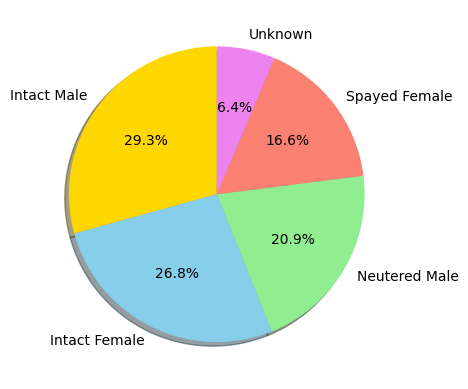

In [25]:
summary = df['Sex upon Intake'].value_counts()

colors = ['gold', 'skyblue', 'lightgreen', 'salmon', 'violet']
plt.pie(summary.values, labels=summary.index,autopct= '%1.1f%%', startangle=90,colors=colors,shadow=True)
plt.show()

From this gender based graph we can figure out
1. `Intact (Male + Female)` make up `55.7%` of the total animals treated
   These types of animals still have their reproductive organs intact and can reproduce. Such animals are generally more aggressive and litters more.
   Special arrangements need to made for controlling them and treating them in a better way

2. `Sterilized (Male + Female)` i.e, `Neutered Male` and `Spayed Female` make up `37.3%` of the total
    These types of animals have had their reproductive organs removed and cannot reproduce.
    They are generally calmer with reduced risk of caner and infections

3. The rest of data is made up by `Unknown` which might be unrecorded data or the animal might be too young to find its gender even after some level of assessment.

In [26]:
counts = df['Intake Type'].value_counts().reset_index()
counts.columns = ['Intake Type', 'Count']

fig = px.bar(counts, x='Intake Type', y='Count',
             text='Count', color='Intake Type',
             title='Number of Animals by Intake Type')

# Improve layout
fig.update_layout(
    xaxis_title='Intake Type',
    yaxis_title='Number of Animals',
    xaxis_tickangle=-45,
    showlegend=False,
    width=800,
    height=550,
    title_font_size=20
)

fig.update_traces(textposition='outside')  # show counts above bars

fig.show()

Its very evident from the graph that most of the animals taken into care are `Stray` which makes sense since these animals does not have proper habitat and living conditions which makes survival very difficult for them. They need to constantly struggle to survive which has adverse affects on their conditions.

Others like owners, public or some wildlife tend to send their animals to be taken care of.

`Euthanasia Request` is very low which means a very small count of animals were to be euthanised maybe because of their adverse or very severe condition which can lead to serious outbreak of diseases.

In [27]:
column_to_analyze = 'Intake Condition'  # example column

# Count occurrences
counts = df[column_to_analyze].value_counts()

# Largest category
max_label = counts.idxmax()
max_count = counts.max()

# Other categories
other_counts = counts.drop(max_label)

# ---------------- Pie Chart: Largest vs Others ----------------
pie = go.Figure()

pie.add_trace(go.Pie(
    labels=[max_label, "Other"],
    values=[max_count, other_counts.sum()],
    hole=0.3,
    marker=dict(colors=['#66b3ff','#ff9999']),
    hoverinfo='label+percent+value'
))

pie.update_layout(
    title=f"Largest Category vs Others ({column_to_analyze})"
)

pie.show()

# ---------------- Bar Chart: Breakdown of Other Categories ----------------
bar = go.Figure()

bar.add_trace(go.Bar(
    x=other_counts.values,
    y=other_counts.index,
    orientation='h',
    marker_color='#ff9999'
))

bar.update_layout(
    title=f"Breakdown of Other Categories ({column_to_analyze})",
    xaxis_title="Count",
    yaxis_title=column_to_analyze,
    yaxis=dict(autorange="reversed")  # largest on top
)

bar.show()

We broke down our data for `Intake Condition` into two parts as `Normal` condition was the most dominating variable which could lead to improper visualization hiding the other factors

From the `Pie Chart` we can see that 88.5% of animals at animal care have `Normal` condtions which means they are healthy. Proper housing and care is all needed to keep them in good health

The rest 11.5% is categorized based on their different medical condtions which they are suffering from.
1. Most of them are injured and sick which means proper medical facilites needs to be provided to these animals to treat them.
2. Other categories are not much in count but still need specialized attention
3. Other and Not recorded are seen to be ambigious requiring better data input to be clear in what exactly the conditon of the animal was. Some of them might be very crucial and due to improper data could lead to adverse affect on them

In [28]:
df['Outcome Type'].value_counts()

Outcome Type
Adoption           72403
Transfer           40056
Return to Owner    36020
Euthanasia          8715
Rto-Adopt           1328
Died                1188
Disposal             575
Unknown              460
Missing               93
Relocate              21
Name: count, dtype: int64

Fate of animals after they were treated

In [ ]:
df['DateTime_df1'] = pd.to_datetime(df['DateTime_df1'], errors='coerce')

df['Outcome_Success'] = df['Outcome Type'].apply(lambda x: 1 if x == 'Adoption' else 0)

# Calculate success rate
success_rate = df.groupby('Intake Type')['Outcome_Success'].mean().reset_index()
success_rate['Outcome_Rate_%'] = success_rate['Outcome_Success'] * 100

# Plot bar chart
fig1 = px.bar(success_rate, x='Intake Type', y='Outcome_Rate_%', 
              text='Outcome_Rate_%',
              title='Outcome Success Rate per Intake Type')
fig1.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig1.show()

top5_outcomes = df['Outcome Type'].value_counts().head(5).reset_index()
top5_outcomes.columns = ['Outcome Type', 'Count']

fig3 = px.bar(top5_outcomes, x='Outcome Type', y='Count',
              text='Count',
              title='Top 5 Outcome Types')
fig3.update_traces(textposition='outside')
fig3.show()


Adoption rate is quite high suggesting that animal lovers are out there adopting animals and take good care of them by providing nurishment, proper habitats and everything to keep them in good health

As we saw Dogs are the most common animals taken care of, so its quite obvious that their adoption rate will be higher in comparison to other animals

In [29]:
df['Outcome Subtype'].value_counts()

Outcome Subtype
Unknown                98060
Partner                33679
Foster                 12539
Rabies Risk             3711
SCRP                    3498
Suffering               3318
Snr                     2868
Aggressive               689
In Kennel                614
Offsite                  481
Medical                  313
In Foster                302
At Vet                   277
Behavior                 184
Enroute                   84
Field                     64
Court/Investigation       52
Underage                  36
Possible Theft            34
In Surgery                22
Prc                       11
Barn                      11
Customer S                 8
Emer                       4
Name: count, dtype: int64

The condition of animals after being treated and taken care of

Let us understand the terminologies to get a more clear idea of what the condition exactly means. Its crucial for an analyst to know the right meaning of the variables in order to write insights in a more systematic and informative way.

1. Unknown – The final outcome for the animal was not recorded or unclear.
2. Partner – The animal was sent to a partner organization, like another shelter, rescue, or NGO.
3. Foster / In Foster – Temporarily placed in a foster home until adoption, recovery, or further evaluation.
4. Rabies Risk – Animals flagged for rabies exposure or related precautionary protocols.
5. SCRP – Likely a special care/rehabilitation program (depends on the shelter).
6. Suffering – Animal in severe pain or distress, often requiring urgent medical intervention or euthanasia.
7. Snr – Senior animal, typically older and may require age-specific care or adoption programs.
8. Aggressive / Behavior – Animals with behavioral challenges, like aggression, fear, or anxiety.
9. In Kennel – Currently housed in the shelter but not yet assigned to foster, partner, or medical care.
10. Offsite – Moved temporarily or permanently to another location (training center, quarantine, etc.).
11. Medical / At Vet / In Surgery / Emer – Animals receiving medical attention, surgery, or emergency care.
12. Enroute – Being transported (to foster, partner, or another shelter).
13. Field – Possibly returned to or monitored in the field (outdoor/feral release).
14. Court/Investigation – Animals involved in legal cases (abuse, neglect, or theft investigations).
15. Underage – Animals too young to be adopted or released, requiring special care.
16. Possible Theft – Suspected stolen animal, often handled with legal oversight.
17. Prc / Barn / Customer S – Likely internal codes for specific programs, housing areas, or customer-related cases (these are low count, specialized).

In [30]:
column_to_analyze = 'Outcome Subtype'

# Count occurrences, exclude 'Unknown', and take top 7
counts = df[column_to_analyze].value_counts()
counts = counts[counts.index != 'Unknown']
top_counts = counts.head(7).reset_index()
top_counts.columns = [column_to_analyze, 'Count']

# Plot bar chart
fig = px.bar(top_counts, x=column_to_analyze, y='Count',
             text='Count', color=column_to_analyze,
             title=f"Top 7 Outcome Subtypes")

# Improve layout
fig.update_layout(
    xaxis_title="Outcome Subtype",
    yaxis_title="Count",
    xaxis_tickangle=-45,
    showlegend=False,
    width=850,
    height=500,
    title_font_size=20
)

fig.update_traces(textposition='outside')  # show counts above bars

fig.show()

Since we have a lot of outcome conditions, we picked out the 7 most dominating outcomes and can see that:

1. Animals are sent to partner organizations probably for better treatment or foster homes until they are adopted or further evaluated
2. Risk of rabies can be seen which is crucial to be treated in order to keep public safety
3. Some animals also need rehabilitation programs
4. Animals still suffering maybe due to sickness, injury needs urgent medical intervention. In extreme cases euthinastion can also be done
5. Senior animals require special adoption program and must be treated in an elderly way

In [31]:
df['DateTime_df1'] = pd.to_datetime(df['DateTime_df1'], errors='coerce')
df = df.dropna(subset=['DateTime_df1'])

df['Month'] = df['DateTime_df1'].dt.to_period('M')
monthly_counts = df.groupby('Month').size().reset_index(name='Count')
monthly_counts['Month'] = monthly_counts['Month'].dt.to_timestamp()

fig = px.line(monthly_counts, x='Month', y='Count',
              markers=True,
              title='Monthly Animal Intake Trend',
              labels={'Month':'Month', 'Count':'Number of Animals'})

fig.update_layout(xaxis_tickformat="%b %Y")
fig.show()

In [32]:
df['Hour'] = df['DateTime_df1'].dt.hour

# Count animals per hour
hourly_counts = df['Hour'].value_counts().sort_index().reset_index()
hourly_counts.columns = ['Hour', 'Count']

# Plot interactive line chart
fig = px.line(hourly_counts, x='Hour', y='Count', markers=True,
              title='Animal Intake by Hour of Day',
              labels={'Hour':'Hour of Day', 'Count':'Number of Animals'})

fig.update_layout(xaxis=dict(tickmode='linear'))  # show all hours
fig.show()

We had a lot of dates to look upon which made it very challenging to analyze and see whats the trend of this animal care. So I am using Plotly to visualize the trend.
1. Grouping the dates by month for a specific year and allows to visually hover and see the exact count of `Number of Animal` treated during that year and for a particular month.
2. Analzying the trend of animal count each day for all years to see which time of day has the most intake

Yearly Analysis is crucial for:
1. Resource planning to keep adequate space, food, medical supplies
2. Supporting financial planning
3. Identifying the growth pattern

Hourly Analysis is crucial for:
1. Staff scheduling so that there are people present to look after animals and record accurate information while intake
2. Managing day to day operational services
3. Public awarness

From our anaylsis

1. Afternoon timings were the most busiest
2. Intake is at the peak during summers and decreases as winters arrive
3. There was a period from 2014 - 2019 when the opertion of the animal care was at the peak. But after 2020 it started rapidly decling owing to the fact that the COVID-19 pandemic breakdown changed a lot of courses in rules and regulation, shelter operations

In [33]:
df_intake = df.dropna(subset=['Age upon Intake'])
df_outcome = df.dropna(subset=['Age upon Outcome'])

# Create subplots: 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Age upon Intake", "Age upon Outcome"))

# Age upon Intake boxplot
fig.add_trace(go.Box(y=df_intake['Age upon Intake'], name='Intake'), row=1, col=1)

# Age upon Outcome boxplot
fig.add_trace(go.Box(y=df_outcome['Age upon Outcome'], name='Outcome'), row=1, col=2)

# Update layout
fig.update_layout(
    title_text="Age Distribution: Intake vs Outcome",
    title_font_size=20,
    yaxis=dict(autorange=True),
    yaxis2=dict(autorange=True),
    width=1000,
    height=500
)

fig.show()

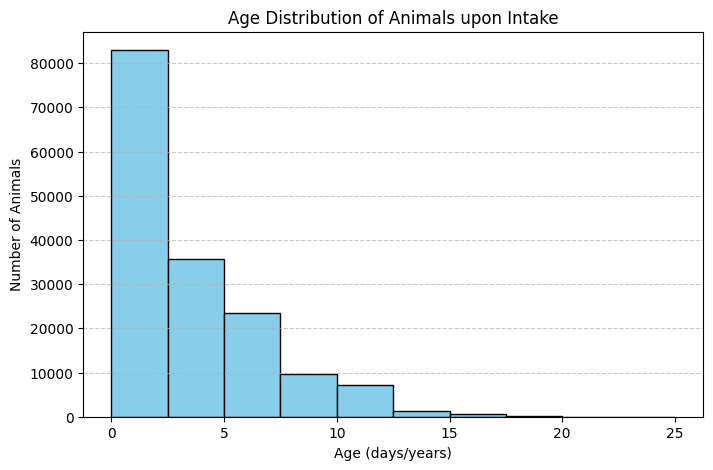

In [34]:
age_intake = pd.to_numeric(df['Age upon Intake'], errors='coerce').dropna()

# Optional: remove negative or unrealistic ages
age_intake = age_intake[age_intake >= 0]

# Create histogram
plt.figure(figsize=(8,5))
plt.hist(age_intake, bins=10, color='skyblue', edgecolor='black')  # bins can be adjusted
plt.xlabel('Age (days/years)')
plt.ylabel('Number of Animals')
plt.title('Age Distribution of Animals upon Intake')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most of the animals treated have a very young age suggesting that newborn animals are at potential risk and needs to be nurtured and taken care of.

Younger animals require vaccination, training, socialization, safety

Older animals (10+ age) needs to be looked after their condition and considered for pet promotion and adoption


In [41]:
counts = df.groupby(['Animal Type_df1', 'Sex upon Intake']).size().reset_index(name='Count')

# Plot grouped bar chart
fig = px.bar(counts, 
             x='Animal Type_df1', 
             y='Count', 
             color='Sex upon Intake', 
             barmode='group',
             title='Animal Type vs Sex upon Intake')

fig.update_layout(
    xaxis_title="Animal Type",
    yaxis_title="Number of Animals",
    xaxis_tickangle=-45,
    legend_title="Sex upon Intake",
    font=dict(size=14)
)

fig.show()

Distinguishing different types of animals and their genders

`Dogs` being the most treated animal at the center shows a wide variety of gender intake followed by cats

In [3]:
remove_list = ['Unknown', 'Other', 'Behavior']

df_filtered = df[~df['Outcome Subtype'].isin(remove_list)].copy()  # make an explicit copy

top_n = 6
top_subtypes = df_filtered['Outcome Subtype'].value_counts().head(top_n).index

# Use .loc to avoid SettingWithCopyWarning
df_filtered.loc[:, 'Outcome Subtype Top'] = df_filtered['Outcome Subtype'].apply(lambda x: x if x in top_subtypes else 'Other')

counts = df_filtered.groupby(['Sex upon Intake', 'Outcome Subtype Top']).size().reset_index(name='Count')

fig = px.bar(counts,
             x='Sex upon Intake',
             y='Count',
             color='Outcome Subtype Top',
             barmode='group',
             title='Sex upon Intake vs Top 6 Outcome Subtypes (excluding Unknown)')

fig.update_layout(
    xaxis_title="Sex upon Intake",
    yaxis_title="Number of Animals",
    xaxis_tickangle=-45,
    legend_title="Outcome Subtype",
    font=dict(size=14)
)

fig.show()


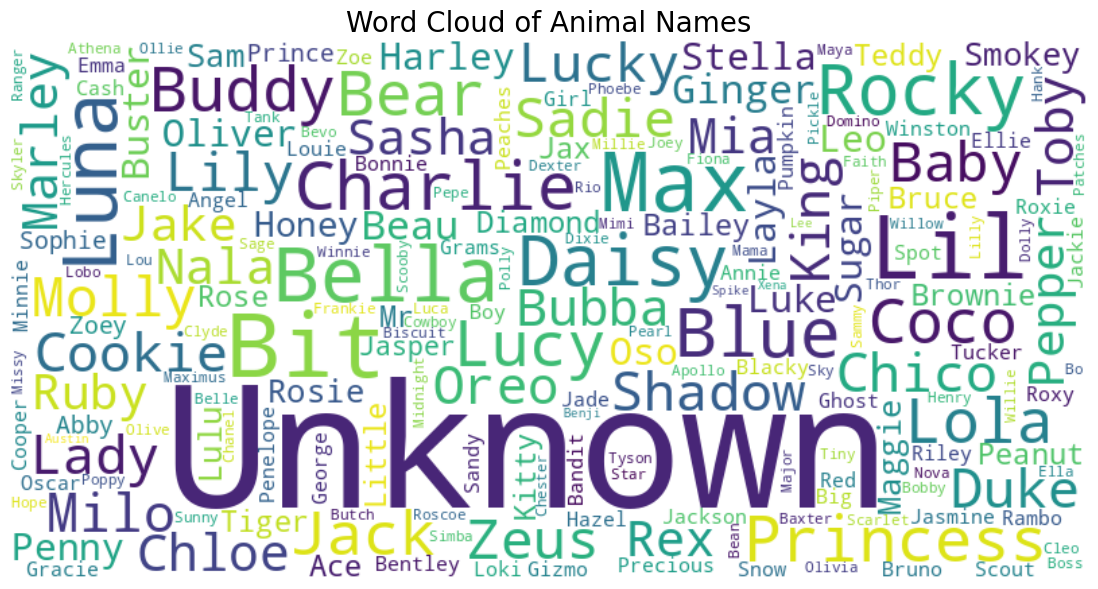

In [5]:
text = " ".join(df['Name_df1'].dropna().astype(str))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='viridis',
                      collocations=False).generate(text)

# Plot the word cloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Animal Names', fontsize=20)
plt.show()


Generating a `Word Cloud` for all those columns like Name, Breed, Color is kinda useful as these are columns with no such signigicant meaning and importance. It represents personal information.

Instead of neglecting it completely, it could be grouped and transformmed into a word cloud which is pleasing to look at, helps identifying the most frequent word used etc

In advanced analytics, its very useful when modelled with `Machine Learning`

I have only shown for `Name_df1` but it can also be formed for `Breed_df1` and `Color_df1`

### FUTURE IMPROVEMENTS

We can truly make this dataset better by combining Machine Learning into so as to drive more useful insights from it and help club different columns using systematic order.

For eg.,

1. Training a model to detect `Found Location` and help categorize the `Intake Type` to fill the missing value by detecting whether the location represents a particular intake type

2. Using `Breed_df1` we can make out the `Animal Type_df1` and fill in the missing values